In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from datetime import datetime

#Neural Nets
import tensorflow as tf

#Bloomberg python library. Is necessary to install bloomberg BLP API and have access to a bloomberg terminal
#from xbbg import blp

from data_eng import get_raw_data, get_selected_stocks

from dotenv import load_dotenv
import os
load_dotenv()

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Get data 
sp500_comp, spx_index, sp500_stock_data = get_raw_data()
top_100_mkt_cap_df, top_100_mkt_cap_prices_df = get_selected_stocks(sp500_stock_data)

# Construção de portfólios

#### Separação de preços e capitalizações de mercado

#### Construção dos Mercados 

* Mercado Fechado: Conjunto de fixo de ações do início ao fim do período considerado
* Mercado Aberto: Conjunto de ações variável rebalanceado mensalmente de acordo com a capitalização de mercado

Na validação das ações que estão diferentes Todas as ações tem um único dia sem o valor de capitalização de mercado em datas distintas com exceção de *MOS US Equity* e *NRG US Equity*.
* MOS US Equity não possui capitalização de mercado para o mês de janeiro de 2004
* NRG US Equity não possui dados de 2004-01-01 a 2005-01-18

Essa ações serão foram removidas do conjunto de dados mas isso não deve impactar nossa modelagem devido ao fato de serem empresas com baixa capitalização de mercado que não vão configurar entra as 100 maiores capitalizações em nenhum momento.

Para as demais companias o valor faltante foi preenchido com o valor de capitalização de mercado do dia anterior usando o método *forward fill*.

#### DWP


* Market Portfolio $$\mu_i =  \frac{X_i}{\displaystyle \sum_{k=1}^{n} X_k}$$
* DWP: $$    \pi_{i}^{p} (t)= \frac{\mu_{i}^{p} (t) }{\displaystyle \sum_{k=1}^{n} \mu_{k}^{p} (t)} \text{, $\forall i \in \{1, \cdots, n \}$} $$

# Teste com portfólio DWP, Mercado e índice S&P500

In [3]:
#Cálculo dos pesos dos portfolios 

# Calculate daily returns
stocks_returns    = np.log(top_100_mkt_cap_prices_df / top_100_mkt_cap_prices_df.shift(1))
sp500_idx_returns =  np.log(spx_index / spx_index.shift(1))


mkt_portfolio_weights = top_100_mkt_cap_df.div(top_100_mkt_cap_df.sum(axis=1),axis=0)

#DWP portfolio
p = 0.5
power_p_transform = mkt_portfolio_weights.apply(lambda mu: mu**p,axis=0 )
dwp_portfolio_weights = power_p_transform.div(power_p_transform.sum(axis=1),axis=0 )

In [4]:
# Calculo dos retornos dos portfolios
# O shift nos pesos considera que as compras das ações com os pesos calculados em D0 
# sejam efetuadas no final do dia, recebendo assim o retorno das ações no fechamento do dia seguinte

#Retorno do portfólio de mercado
mkt_return = (mkt_portfolio_weights.shift(1) * stocks_returns).sum(axis=1)

# Retorno do Portfólio DWP
dwp_return = (dwp_portfolio_weights.shift(1) * stocks_returns).sum(axis=1)


## Comparação entre retorno dos portfolios

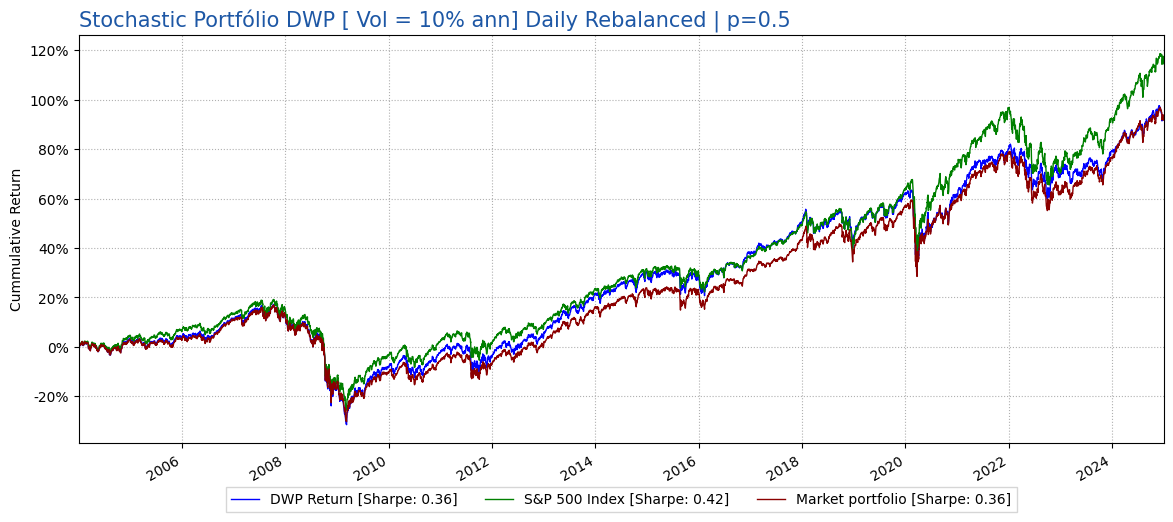

In [5]:
# Normalize every strategy to 10% ann vol (ex-post)
dwp_ts    = dwp_return.copy()
mkt_ts    = mkt_return.copy()

spx_ts = sp500_idx_returns['spx_index'].copy()
spx_ts = spx_ts.reindex(mkt_return.index)


dwp_vol_scaler    = 0.1/dwp_ts.std()/np.sqrt(252)
spx_ts_vol_scaler = 0.1/spx_ts.std()/np.sqrt(252)
mkt_scaler        = 0.1/mkt_ts.std()/np.sqrt(252)

dwp_ts *= dwp_vol_scaler
spx_ts *= spx_ts_vol_scaler
mkt_ts *= mkt_scaler

dwp_ts_sr = np.sqrt(252)*dwp_ts.mean()/dwp_ts.std()
spx_ts_sr = np.sqrt(252)*spx_ts.mean()/spx_ts.std()
mkt_ts_sr = np.sqrt(252)*mkt_ts.mean()/mkt_ts.std()


plt.figure(figsize=(14,6))
ax = plt.subplot(1,1,1)

((dwp_ts+1).cumprod()-1).plot(label=f'DWP Return [Sharpe: {dwp_ts_sr:.2f}]', linewidth=1.0, color='blue')
((spx_ts+1).cumprod()-1).plot(label=f'S&P 500 Index [Sharpe: {spx_ts_sr:.2f}]', linewidth=1.0, color='green')
((mkt_ts+1).cumprod()-1).plot(label=f'Market portfolio [Sharpe: {mkt_ts_sr:.2f}]', linewidth=1.0, color='darkred')

plt.grid(linestyle=':')
ax.margins(x=0)
ax.yaxis.set_major_formatter(lambda x,y : f'{x:.0%}')
ax.axes.set_xlabel(None)
ax.axes.set_ylabel('Cummulative Return')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),fancybox=False, shadow=False, ncol=3)
plt.title(f'Stochastic Portfólio DWP [ Vol = 10% ann] Daily Rebalanced | p={p}', loc='left', fontsize=15, color=(29/255, 87/255, 165/255))
plt.show()

## Observação

Achei o desempenho dos portfólios razoávelmente satisfatório considerando que ele não pega o upside de diversas empresas que entraram no índice S&P depois de 2004. 
Há fatores relevantes a se considerar como viés de sobrevivência e custos de transação. Para isso faremos simulações com rebalanceamento semanal e mensal e tentaremos construir um portfólio de mercado com universo de ações variável com suas componenetes rebalanceadas mensalmente. Isso eliminará parte do viés de sobrevivência e trará mais credibilidade às simulações.

## Testes com calculo numérico de gradiente do tensor flow 
* Aqui o operador que calcula as funções geradoras é vetorizado como uma função do gradiente e comparamos os valores de pesos gerados para o portfólio com gradiente calculado por aproximação e para o portfólio gerado a partir do calculo do gradiente usando uma função analítica. 
* Esse teste não trata somente de verificar a qualidade da aproximação do cálculo de gradiente do tensorflow para o operador que gera os portfólios, mas também para garantir que o backpropagation calculado dentro da biblioteca possui um erro pequeno, pois, usando essa biblioteca não precisamos adaptar o algoritmo de backpropagation para a função de custo customizada que utilizaremos.

Apenas lembrando que

$$
\pi_i (t) = \left ( D_i \log G(\mu (t) ) + 1 - \displaystyle \sum_{j=1}^{n} \mu_j (t) D_j \log G (\mu (t)) \right ) \mu_i (t) \text{, $1 \leq i \leq n$.}
$$

E a versão vetorizada desse operador é pode ser representada da seguinte forma: 

$$
\pi(t) = \left( \nabla \log G (\mu (t)) + 1 - \left( \mu(t) \odot \nabla \log G(\mu (t)) \cdot \mathbf{1} \right) \right) \odot \mu(t)
$$
onde $\odot$ é a multiplicação elemento a elemento entre $2$ vetores, $\cdot$ é o produto interno e $\mathbf{1}$ é o vetor n-dimensional em que todos os elementos são iguais a 1.    





In [6]:
grad_log_g = lambda x, p: (x**(p-1)) / np.sum((x**p), axis=1, keepdims=True)
analytical_grad = grad_log_g(mkt_portfolio_weights.values, p)

In [7]:
def G_tf(x, p):
    return tf.pow(tf.reduce_sum(tf.pow(x, p), axis=1, keepdims=True), 1.0 / p)

In [8]:
#Calcula gradiente com diferenciação automática do tensor flow
x_tf = tf.convert_to_tensor(mkt_portfolio_weights, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(x_tf)
    g_value = tf.math.log(G_tf(x_tf, p)) #logaritmo de G
    
tf_grad = tape.gradient(g_value, x_tf).numpy()

In [9]:
def FGP_operator(mu: np.array, grad_G):
    return np.multiply(mu, grad_G + 1 - np.sum(np.multiply(mu, grad_G), axis=1, keepdims=True))


In [10]:
mse_per_row = np.mean((analytical_grad - tf_grad) ** 2, axis=1)

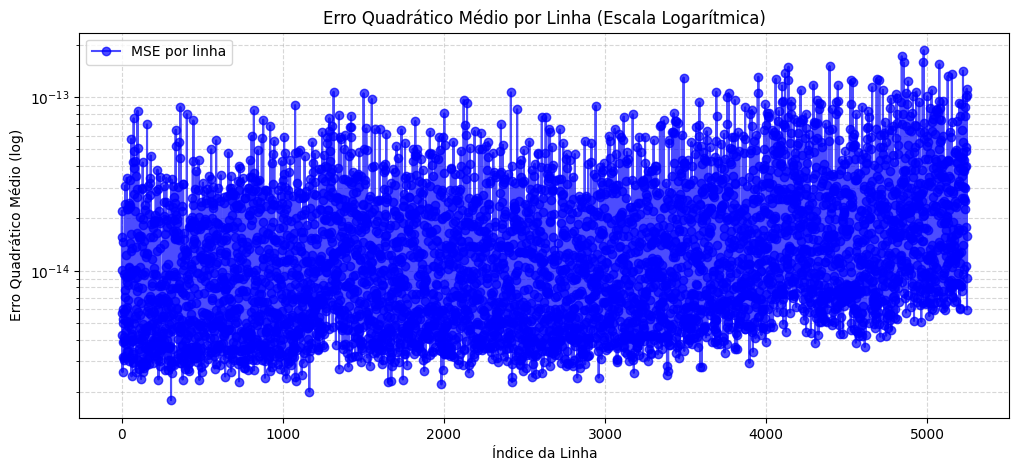

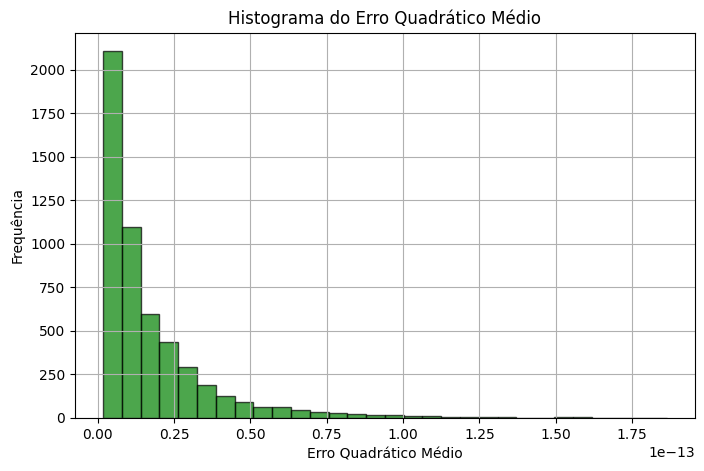

In [11]:
# Criando o gráfico de linhas com escala logarítmica no eixo y
plt.figure(figsize=(12, 5))
plt.plot(mse_per_row, marker='o', linestyle='-', color='b', alpha=0.7, label="MSE por linha")
plt.yscale("log")  # Define escala logarítmica no eixo y
plt.xlabel("Índice da Linha")
plt.ylabel("Erro Quadrático Médio (log)")
plt.title("Erro Quadrático Médio por Linha (Escala Logarítmica)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)  # Grade para escala log
plt.show()

# Criando o histograma da distribuição do MSE
plt.figure(figsize=(8, 5))
plt.hist(mse_per_row, bins=30, color='g', alpha=0.7, edgecolor='black')
plt.xlabel("Erro Quadrático Médio")
plt.ylabel("Frequência")
plt.title("Histograma do Erro Quadrático Médio")
plt.grid(True)
plt.show()

Podemos observar que a diferenciação automática do tensor flow tem um erro muito pequeno nesse exemplo.

# REDE NEURAL

## Separação dos dados

In [12]:
##################################################
# # MONTAGEM DAS AMOSTRAS DE TREINO E DE TESTE # #
##################################################


# Copiando os dados gerados anteriormente 
# Pesos do Portfolio de mercado
mu_t_df = mkt_portfolio_weights.copy()

# Retorno das ações
R_t_df =  stocks_returns.copy()

#Retorno do portfólio de mercado
#Iloc[1:] para iniciar as series em 2004-01-05 e eliminar os valores NaN decorrentes do calculo do retorno. 
mu                   = tf.convert_to_tensor(mu_t_df.iloc[1:].values, dtype=tf.float32) # Pesos de mercado
mkt_ret              = tf.convert_to_tensor(mkt_return.iloc[1:], dtype=tf.float32)              # Retorno do portfólio de mercado
R_t_df               = tf.convert_to_tensor(R_t_df.iloc[1:].values, dtype=tf.float32)

indices = np.arange(len(mu))
train_idx, test_idx = train_test_split(indices, test_size=0.1, shuffle=False)

# Split datasets

#Treino
mu_train            = tf.convert_to_tensor(mu.numpy()[train_idx], dtype=tf.float32)
mkt_ret_train       = tf.convert_to_tensor(mkt_ret.numpy()[train_idx] , dtype=tf.float32)
stock_returns_train = tf.gather(R_t_df, train_idx)

# Teste
mu_test            = tf.convert_to_tensor(mu.numpy()[test_idx], dtype=tf.float32)
mkt_ret_test       = tf.convert_to_tensor(mkt_ret.numpy()[test_idx], dtype=tf.float32)
stock_returns_test = tf.gather(R_t_df, test_idx)


# Input da rede
training_input = tf.concat([mu_train, stock_returns_train], axis=1)
test_input     = tf.concat([mu_test,  stock_returns_test], axis=1)

input_dim =  training_input.shape[1] # 200

## Definição da Rede Neural

In [13]:
import tensorflow as tf

##################################################
############### DESIGN DA REDE ###################
##################################################

class PINN(tf.keras.Model):
    def __init__(self, input_dim=200):
        """
        Inicializa o modelo PINN com uma arquitetura otimizada para aprender
        funções suaves (C^2) e côncavas.

        Args:
            input_dim (int): A dimensionalidade da entrada da rede (padrão: 200).
        """
        super(PINN, self).__init__()
        
        initializer = tf.keras.initializers.GlorotNormal()
        l2_regularizer = tf.keras.regularizers.l2(0.001)

        # O corpo principal da rede é definido usando tf.keras.Sequential
        # para maior clareza e manutenibilidade.
        self.hidden_layers = tf.keras.Sequential([
            # Camada de Entrada
            tf.keras.layers.InputLayer(input_shape=(input_dim,)),
            
            # Bloco Oculto 1
            # Usamos 'swish' por ser suave (C^∞) e ter ótimo desempenho.
            # A arquitetura de largura constante (128 neurônios) é robusta.
            tf.keras.layers.Dense(128, activation='swish', kernel_initializer=initializer),
            tf.keras.layers.BatchNormalization(),
            
            # Bloco Oculto 2
            tf.keras.layers.Dense(128, activation='swish', kernel_initializer=initializer, kernel_regularizer=l2_regularizer),
            tf.keras.layers.BatchNormalization(),
            
            # Bloco Oculto 3
            tf.keras.layers.Dense(128, activation='swish', kernel_initializer=initializer, kernel_regularizer=l2_regularizer),
            # Nota: Dropout foi removido para garantir derivadas mais estáveis.
        ])
        
        # A camada de saída permanece a mesma, pois 'softplus' garante G > 0.
        self.output_layer = tf.keras.layers.Dense(1, activation='softplus')

    def call(self, inputs):
        """
        Executa a passagem para a frente (forward pass).
        A lógica de separação e concatenação foi removida por ser redundante.
        """
        z = self.hidden_layers(inputs)
        return self.output_layer(z)

## Função de custo modificada

In [14]:
def compute_cumulative_returns(x, ret, ret_mkt, grad_log_G_X):
    """_summary_

    Args:
        x (_type_): Market portfolio weights
        ret (_type_): Stocks Returns
        ret_mkt (_type_): Market Return
        grad_log_G_X (_type_): Gradient of Log of the network output 

    Returns:
        Network generated portfolio cumulative return, Market cumulative return : Cumulative returns 
    """
    inner_prod = tf.reduce_sum(x * grad_log_G_X, axis=1)
    pi_t = ((grad_log_G_X + 1) - tf.expand_dims(inner_prod, axis=1))*x

    # Shift nos pesos para considerar trade date no final do dia
    pi_t_shifted = tf.concat([tf.zeros_like(pi_t[:1]), pi_t[:-1]], axis=0)

    # Retorno do portfólio
    port_ret = tf.reduce_sum(pi_t_shifted * ret, axis=1)
    gross_returns = 1 + port_ret
    ret_acumulado = tf.math.cumprod(gross_returns)

    # Retorno do mercado
    gross_mkt_returns = 1 + ret_mkt
    ret_acumulado_mkt = tf.math.cumprod(gross_mkt_returns)

    return ret_acumulado, ret_acumulado_mkt


In [15]:
def custom_loss(model, x, ret, ret_mkt):

    ###############################
    # # Derivatives Calculation # #  
    ###############################
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x)
            G_x_pred = model(tf.concat([x, ret], axis=1))  # G(x, r)
            log_G_x_pred = tf.math.log(G_x_pred + 1e-7)
        
        grad_log_G_X = tape1.gradient(log_G_x_pred, x)
        grad_G       = tape1.gradient(G_x_pred, x)  # ∇G(x)

    H_G = tape2.batch_jacobian(grad_G, x)  # ∇²G(x) - Hessian

    ########################################
    # # Functionally Generated Portfolio # #
    ########################################
    inner_prod = tf.reduce_sum(x * grad_log_G_X, axis=1)
    pi_t = ((grad_log_G_X + 1) - tf.expand_dims(inner_prod, axis=1))*x

    # Shift nos pesos para considerar trade date no final do dia
    pi_t_shifted = tf.concat([tf.zeros_like(pi_t[:1]), pi_t[:-1]], axis=0)

    # Retorno do portfólio
    port_ret = tf.reduce_sum(pi_t_shifted * ret, axis=1)

    #############################
    # # Matriz de Covariância # #
    #############################
    ret_mean = tf.reduce_mean(ret, axis=0, keepdims=True)  
    ret_centered = ret - ret_mean  
    n_samples = tf.cast(tf.shape(ret)[0], tf.float32)
    Sigma = tf.matmul(ret_centered, ret_centered, transpose_a=True) / (n_samples - 1.0)

    ######################################################
    # # Covariância relativa ao portfolio gerado (tau) # #
    ######################################################
    T = pi_t.shape[0]

    drift_array = tf.TensorArray(dtype=tf.float32, size=T)
    for t in range(T):
        row_t = pi_t[t, :]  # Get row t (shape [100])
        mu_t  = x[t,:]
        
        sigma_market  = tf.matmul(tf.expand_dims(row_t, 0), Sigma)  # [1,100] * [100,100] = [1,100]
      
        sigma_mm = tf.matmul(
        tf.matmul(tf.expand_dims(row_t, 0), Sigma),  # [1,100] @ [100,100] → [1,100]
        tf.expand_dims(row_t, 1)                     # [1,100] @ [100,1] → [1,1]
         )
        sigma_mm = tf.squeeze(sigma_mm)

        tau_matrix_t = Sigma -  tf.transpose(tf.tile(tf.transpose(sigma_market), [1, sigma_market.shape[1]])) - tf.tile(tf.transpose(sigma_market), [1, sigma_market.shape[1]]) + sigma_mm

        mu_outer = tf.einsum('i,j->ij', mu_t, mu_t)
        contraction = tf.einsum('ij,ij,ij->', H_G[t], tau_matrix_t, mu_outer)
        drift_dt = -0.5 / G_x_pred[t] * contraction
        drift_array = drift_array.write(t, drift_dt)

    drift_dt_tensor = drift_array.stack()

    #########################
    # # Integral do Drift # #
    #########################

    T = tf.shape(drift_dt_tensor)[0]
    delta_t = 1.0  # ou outro valor de passo de tempo, se não for unitário

    # Soma intermediária para regra do trapézio
    sum_trap = tf.reduce_sum(drift_dt_tensor[1:T-1])
    I_trap = delta_t * (0.5 * drift_dt_tensor[0] + sum_trap + 0.5 * drift_dt_tensor[T - 1])

    # Soma intermediária para regra de Simpson
    even_sum = tf.reduce_sum(drift_dt_tensor[2:T-1:2])  # f2, f4, ...
    odd_sum  = tf.reduce_sum(drift_dt_tensor[1:T:2])    # f1, f3, ...
    I_simp = (delta_t / 3.0) * (drift_dt_tensor[0] + 2.0 * even_sum + 4.0 * odd_sum + drift_dt_tensor[T - 1])

    # Se T ímpar (i.e., número de pontos par), aplica Simpson; senão Trapézio
    integral_dg = tf.where(tf.equal(T % 2, 1), I_simp, I_trap)

    #######################
    # # Master Eq Error # #
    #######################
    loss = (tf.math.log(tf.reduce_sum(port_ret)/tf.reduce_sum(mkt_ret) )) - (tf.math.log((G_x_pred[-1]/G_x_pred[0])) + integral_dg)

    mse_loss = tf.reduce_mean(tf.square(loss))


    return -(mse_loss), {
            'excess_return_series': port_ret,
            'grad_log_G_X_norm': tf.norm(grad_log_G_X, ord='euclidean', axis=1),
         }


In [16]:
def custom_loss_2(model, x, ret, ret_mkt):
    ###############################
    # # Derivatives Calculation # #  
    ###############################
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x)
            # Ensure positive output with softplus + epsilon
            G_x_pred = model(tf.concat([x, ret], axis=1)) + 1e-7
            log_G_x_pred = tf.math.log(G_x_pred)
        
        grad_log_G_X = tape1.gradient(log_G_x_pred, x)
        grad_G = tape1.gradient(G_x_pred, x)  # ∇G(x)
        del tape1

    H_G = tape2.batch_jacobian(grad_G, x)  # ∇²G(x) - Hessian [batch, 100, 100]
    del tape2

    ########################################
    # # Functionally Generated Portfolio # #
    ########################################
    inner_prod = tf.reduce_sum(x * grad_log_G_X, axis=1)
    pi_t = ((grad_log_G_X + 1) - tf.expand_dims(inner_prod, axis=1)) * x

    # Shift weights for end-of-day trading
    pi_t_shifted = tf.concat([tf.zeros_like(pi_t[:1]), pi_t[:-1]], axis=0)

    # Portfolio return - clip to avoid log(negative)
    port_ret = tf.reduce_sum(pi_t_shifted * ret, axis=1)
    port_ret = tf.clip_by_value(port_ret, -0.99, 10.0)  # Prevent < -100% returns

    #############################
    # # Covariance Matrix Σ # # #
    #############################
    ret_mean = tf.reduce_mean(ret, axis=0, keepdims=True)  
    ret_centered = ret - ret_mean  
    n_samples = tf.cast(tf.shape(ret)[0], tf.float32)
    Sigma = tf.matmul(ret_centered, ret_centered, transpose_a=True) / (n_samples - 1.0)  # [100, 100]

    ######################################################
    # # Vectorized Drift Calculation (No Python Loops) # #
    ######################################################
    # Batch-compute σ_market = π_t @ Σ [batch, 100]
    sigma_market_batch = tf.matmul(pi_t, Sigma)
    
    # σ_mm = π_t @ Σ @ π_t^T [batch]
    sigma_mm_batch = tf.einsum('bi,bi->b', pi_t, sigma_market_batch)
    
    # τ_ij = Σ_ij - σ_market_i - σ_market_j + σ_mm
    tau_matrix = (
        tf.expand_dims(Sigma, 0) - 
        tf.expand_dims(sigma_market_batch, 1) - 
        tf.expand_dims(sigma_market_batch, 2) + 
        tf.reshape(sigma_mm_batch, [-1, 1, 1])
    )
    
    # μ_outer = μ ⊗ μ [batch, 100, 100]
    mu_outer_batch = tf.einsum('bi,bj->bij', x, x)
    
    # Contract: H_G ⊙ τ ⊙ μ_outer
    contraction = tf.einsum('bij,bij,bij->b', H_G, tau_matrix, mu_outer_batch)
    
    # Drift per timestep - add epsilon to denominator
    drift_dt = -0.5 * contraction / (tf.squeeze(G_x_pred) + 1e-7)  # [batch]

    #########################
    # # Integral of Drift # #
    #########################
    # Always use trapezoidal rule for numerical stability
    T = tf.shape(drift_dt)[0]
    delta_t = 1.0
    integral_dg = delta_t * (0.5 * drift_dt[0] + tf.reduce_sum(drift_dt[1:-1]) + 0.5 * drift_dt[-1])

    #######################
    # # Master Eq Error # #
    #######################
    # Correct cumulative return calculation
    cumulative_port = tf.math.cumprod(1 + port_ret)[-1]
    cumulative_mkt = tf.math.cumprod(1 + tf.squeeze(ret_mkt))[-1]  # Fixed dimension issue
    
    # Use safe division and logging
    port_return_ratio = cumulative_port / (cumulative_mkt + 1e-7)
    log_port_return = tf.math.log(port_return_ratio + 1e-7)
    
    # Growth ratio with safe logging
    growth_ratio = G_x_pred[-1, 0] / (G_x_pred[0, 0] + 1e-7)
    log_growth = tf.math.log(growth_ratio + 1e-7)
    
    loss = log_port_return - (log_growth + integral_dg)

    # Regularize loss to prevent NaN
    mse_loss = tf.reduce_mean(tf.square(loss)) + 1e-6 * tf.reduce_mean(tf.square(grad_G))

    return mse_loss, {  # Return positive MSE for minimization
        'excess_return_series': port_ret,
        'grad_log_G_X_norm': tf.norm(grad_log_G_X, ord='euclidean', axis=1),
    }

## Loop de treinamento 

In [17]:
# Prepara o banco de dados  (sem embaralhamento para manter a dependencia tempral das series)
batch_size = 252
dataset = tf.data.Dataset.from_tensor_slices(
    (mu_train, stock_returns_train, mkt_ret_train)
).batch(batch_size)

# Model Compilation
model = PINN(input_dim=200)  # 100 (x) + 100 (r_t) = 200
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001)


###########################################################
## Vetores para armazenamento de métricas de Treinamento ##
###########################################################
avg_epoch_loss_vect = []

grad_norms_per_epoch = {}
excess_of_ret_per_epoch = {}

grad_norms_batch_vect     = []
excess_ret_per_batch_vect = []


# Training loop (batches processed in sequence)
num_epochs = 600
for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0
    for x_batch, ret_batch, ret_mkt_batch in dataset:
        with tf.GradientTape() as tape:
            loss_value, metrics_dics = custom_loss_2(model, x_batch, ret_batch, ret_mkt_batch)

        gradients = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        grad_norms_batch_vect = grad_norms_batch_vect + metrics_dics['grad_log_G_X_norm'].numpy().tolist()
        excess_ret_per_batch_vect = excess_ret_per_batch_vect + metrics_dics['excess_return_series'].numpy().tolist()

        epoch_loss += loss_value.numpy()
        num_batches += 1

    avg_epoch_loss = epoch_loss / num_batches
    
    avg_epoch_loss_vect.append(avg_epoch_loss)
    grad_norms_per_epoch[str(epoch)]  = grad_norms_batch_vect
    excess_of_ret_per_epoch[str(epoch)]  = excess_ret_per_batch_vect

    grad_norms_batch_vect     = []
    excess_ret_per_batch_vect = []

    # Printa a perda a cada 10 épocas
    if epoch % 50==0:
        print(f"Epoch {epoch}/{num_epochs}, Avg Loss: {avg_epoch_loss}")

print(f"Epoch {epoch}/{num_epochs}, Avg Loss: {avg_epoch_loss}")

Epoch 0/600, Avg Loss: 0.00016328644414898008
Epoch 50/600, Avg Loss: 1.1091677151853219e-05
Epoch 100/600, Avg Loss: 6.97224913892569e-06
Epoch 150/600, Avg Loss: 1.0256574569211807e-05
Epoch 200/600, Avg Loss: 1.1996734716746005e-09
Epoch 250/600, Avg Loss: 1.0139081496163271e-05
Epoch 300/600, Avg Loss: 4.726194674731232e-06
Epoch 350/600, Avg Loss: 4.483397788135335e-06
Epoch 400/600, Avg Loss: 4.256540250935359e-06
Epoch 450/600, Avg Loss: 4.133813490625471e-06
Epoch 500/600, Avg Loss: 3.359445599926403e-06
Epoch 550/600, Avg Loss: 2.453623665132909e-06
Epoch 599/600, Avg Loss: 2.232187398476526e-06


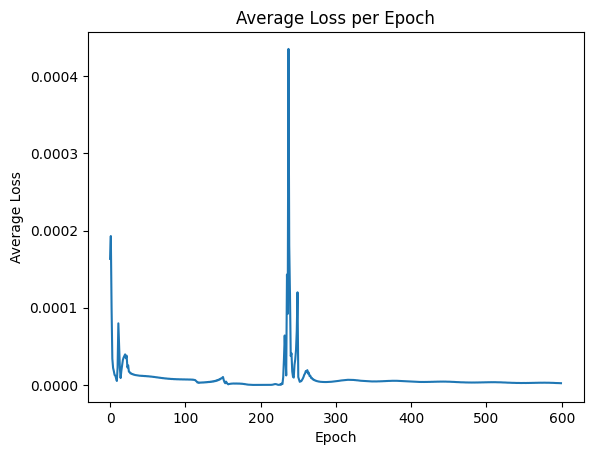

In [18]:
plt.plot(avg_epoch_loss_vect)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss per Epoch")
plt.show()

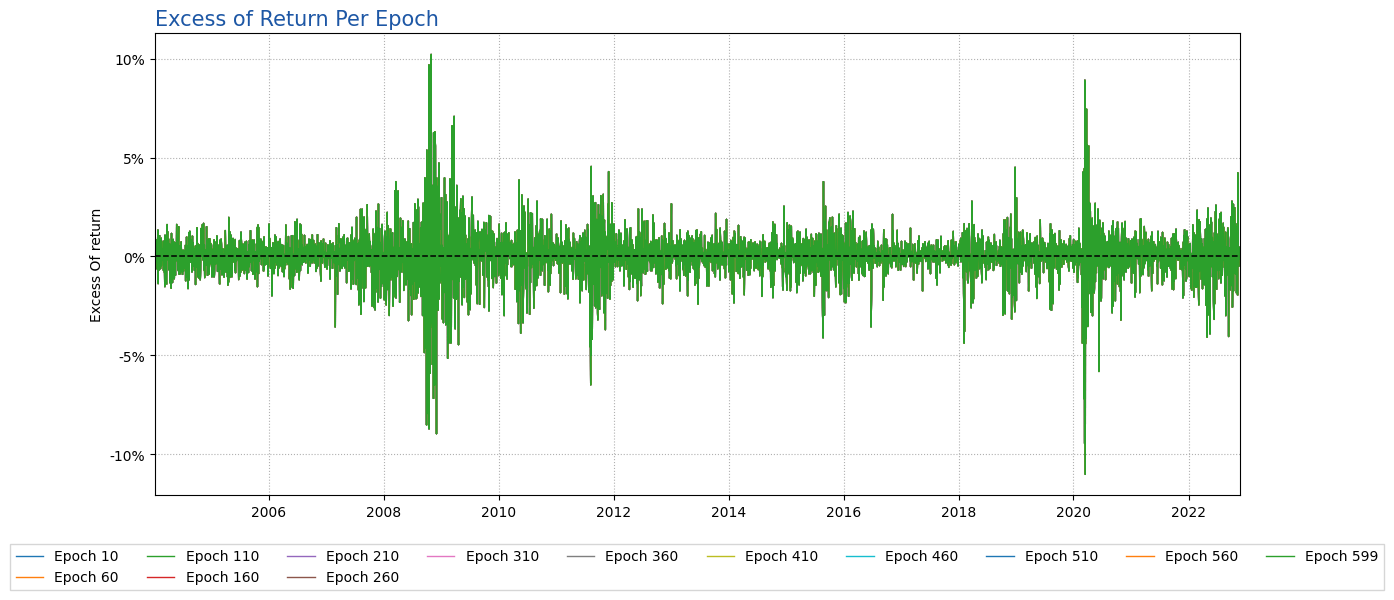

In [19]:
plt.figure(figsize=(14,6))
ax = plt.subplot(1,1,1)

epochs_analysed = [str(i) for i in range(10,len(excess_of_ret_per_epoch),50)]+[str(len(excess_of_ret_per_epoch)-1)]

for i in epochs_analysed: 
    plt.plot(mu_t_df.iloc[1:4723].index, excess_of_ret_per_epoch[i],label=f'Epoch {i}', linewidth=1.0)

plt.axhline(y=0, color='black', linestyle='--', linewidth=1.1)
plt.grid(linestyle=':')
ax.margins(x=0)
ax.yaxis.set_major_formatter(lambda x,y : f'{x:.0%}')
ax.axes.set_xlabel(None)
ax.axes.set_ylabel('Excess Of return')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),fancybox=False, shadow=False, ncol=10)
plt.title(f'Excess of Return Per Epoch', loc='left', fontsize=15, color=(29/255, 87/255, 165/255))
plt.show()

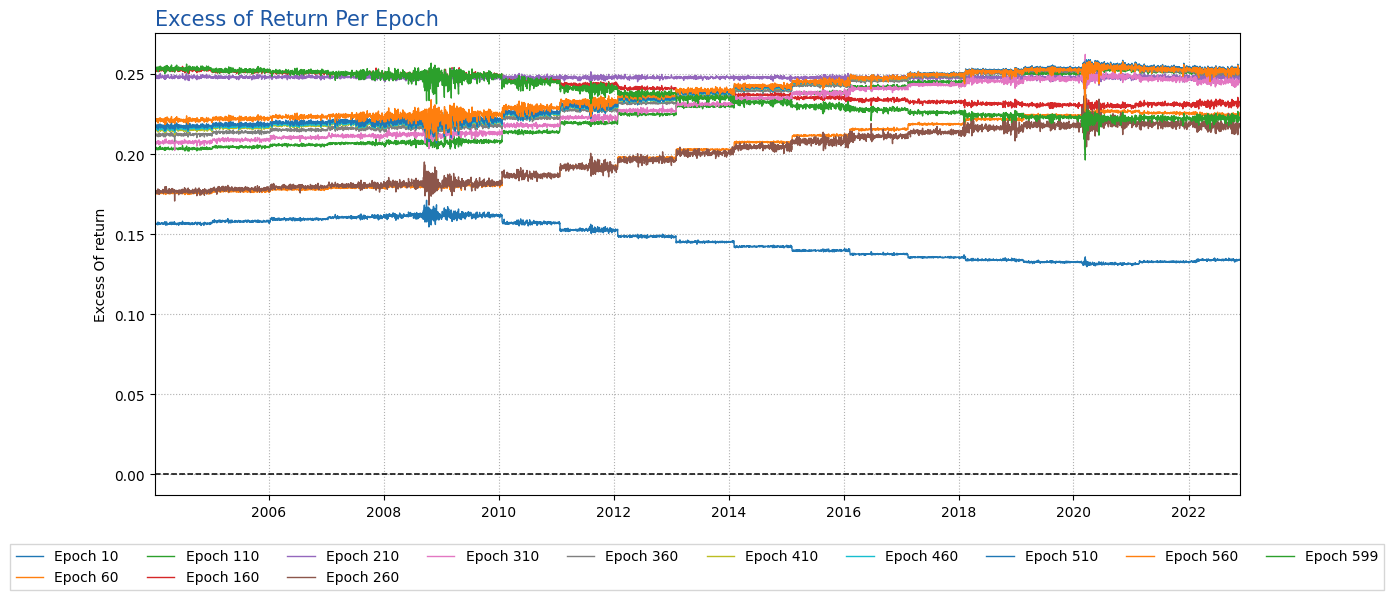

In [20]:
plt.figure(figsize=(14,6))
ax = plt.subplot(1,1,1)

epochs_analysed = [str(i) for i in range(10,len(grad_norms_per_epoch),50)]+[str(len(grad_norms_per_epoch)-1)]

for i in epochs_analysed: 
    plt.plot(mu_t_df.iloc[1:4723].index, grad_norms_per_epoch[i],label=f'Epoch {i}', linewidth=1.0)

plt.axhline(y=0, color='black', linestyle='--', linewidth=1.1)
plt.grid(linestyle=':')
ax.margins(x=0)
#ax.yaxis.set_major_formatter(lambda x,y : f'{x:.0%}')
ax.axes.set_xlabel(None)
ax.axes.set_ylabel('Excess Of return')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),fancybox=False, shadow=False, ncol=10)
plt.title(f'Excess of Return Per Epoch', loc='left', fontsize=15, color=(29/255, 87/255, 165/255))
plt.show()

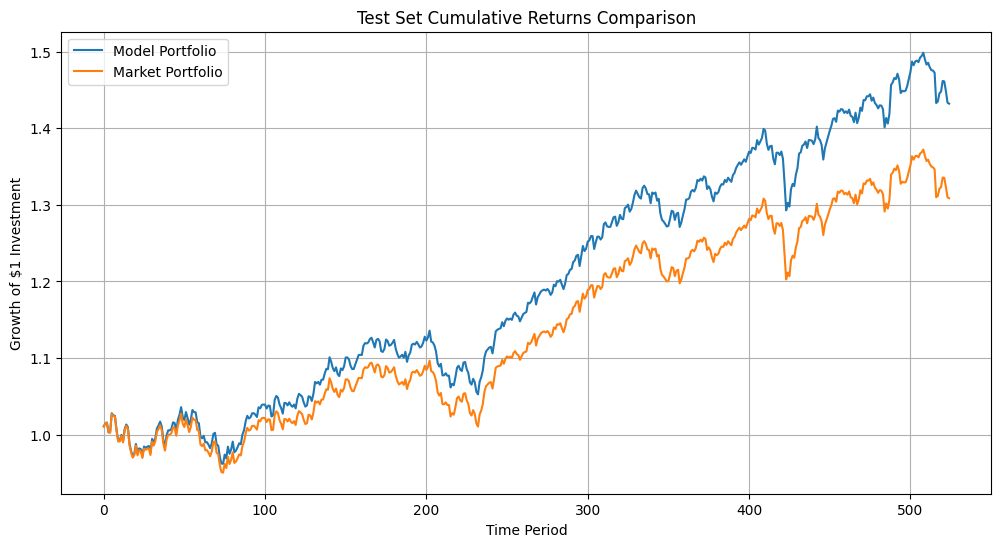

In [21]:
# ##################################################
# ########### TEST SET EVALUATION ##################
# ##################################################

# # Compute portfolio returns on the test set
with tf.GradientTape() as tape:
    tape.watch(mu_test)
    # Generate predictions in inference mode
    test_inputs = tf.concat([mu_test, stock_returns_test], axis=1)
    G_test = model(test_inputs, training=False)  # Disable dropout/bn training
    log_G_test = tf.math.log(G_test)

# Calculate gradients for portfolio weights
grad_log_G_mu_test = tape.gradient(log_G_test, mu_test)

# Compute portfolio weights (pi_t)
inner_prod_test = tf.reduce_sum(mu_test * grad_log_G_mu_test, axis=1, keepdims=True)
grad_log_G_plus_1_test = grad_log_G_mu_test + 1.0
sum_terms_test = grad_log_G_plus_1_test - inner_prod_test
pi_t_test = sum_terms_test * mu_test

# Calculate portfolio returns
port_ret_test = tf.reduce_sum(pi_t_test * stock_returns_test, axis=1)

# Convert to numpy for analysis
port_ret_test_np = port_ret_test.numpy()
market_ret_test_np = mkt_ret_test.numpy().flatten()  # Market returns

# Calculate cumulative returns
cumulative_model = np.cumprod(1 + port_ret_test_np)
cumulative_market = np.cumprod(1 + market_ret_test_np)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_model, label="Model Portfolio")
plt.plot(cumulative_market, label="Market Portfolio")
plt.title("Test Set Cumulative Returns Comparison")
plt.xlabel("Time Period")
plt.ylabel("Growth of $1 Investment")
plt.legend()
plt.grid(True)
plt.show()



In [22]:
import numpy as np

def calcular_g_x_t(df, p):
    return np.power(np.sum(np.pow(df,p),axis=1), 1/p)

In [23]:
G_p = calcular_g_x_t(mu_test.numpy(), 0.5)

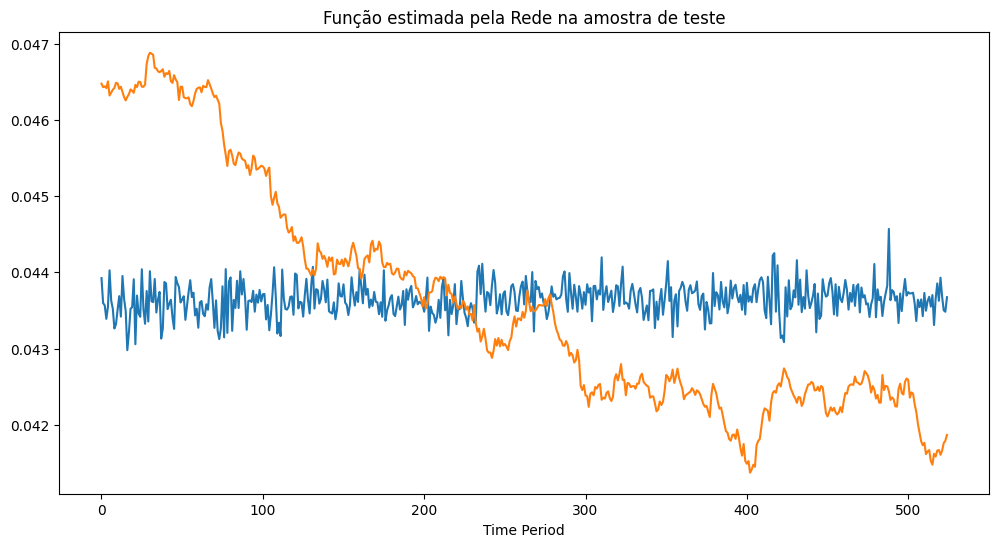

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(G_test.numpy()/( np.sqrt( np.sum(G_test.numpy()**2) )), label="Model Portfolio")
plt.plot(G_p/( np.sqrt( np.sum(G_p**2) )), label="Model G_p")
plt.title("Função estimada pela Rede na amostra de teste")
plt.xlabel("Time Period")
plt.show()